In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils.vis_utils import plot_model
PATH = Path('/content/gdrive/My Drive/REU Materials/Data')

In [3]:
X_train = pd.read_csv(PATH/'train.csv')

In [4]:
X_train.head()

,Unnamed: 0,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10
0,631052,0.6,0.8,0.4,0.8,0.8,1.0,0.2,0.6,0.4,0.8,0.8,0.6,0.6,0.6,1.0,0.2,0.6,0.6,0.4,0.6,0.8,0.6,0.4,0.8,0.8,1.0,0.4,0.4,1.0,0.6,0.6,0.2,0.6,0.4,0.6,0.8,1.0,0.4,0.6,0.6,0.8,0.6,0.6,0.6,0.8,0.4,0.8,0.2,0.6,0.6
1,770974,0.2,0.2,1.0,1.0,0.6,1.0,0.2,0.2,0.2,0.6,0.2,0.6,0.6,0.2,0.2,0.2,0.6,0.6,0.2,0.2,1.0,0.6,0.2,0.6,0.2,1.0,0.2,0.6,1.0,1.0,1.0,1.0,1.0,0.2,1.0,0.2,1.0,0.6,1.0,0.2,0.6,0.2,0.6,0.2,0.6,0.2,1.0,0.6,0.6,0.6
2,811924,0.2,0.6,0.8,0.6,1.0,0.2,0.2,0.8,0.8,0.6,0.4,1.0,0.8,0.4,0.2,0.4,0.4,0.4,0.4,0.2,0.4,0.8,0.8,0.4,0.2,1.0,0.4,0.6,0.2,0.4,0.8,0.2,0.8,0.2,0.6,0.2,0.8,0.2,0.8,0.8,1.0,0.4,0.4,0.2,0.8,0.6,1.0,0.8,1.0,0.4
3,964914,0.4,0.6,0.8,0.6,0.8,0.4,0.4,0.4,0.6,0.4,0.8,0.8,0.4,0.8,0.4,0.4,0.4,0.2,0.2,0.4,0.4,0.8,0.2,0.8,0.2,0.8,0.2,0.8,0.8,0.8,0.4,0.6,0.6,0.4,0.6,0.4,0.4,0.2,0.2,0.6,0.6,0.8,0.8,0.2,0.6,0.2,0.8,0.6,0.8,0.8
4,691563,0.4,1.0,0.6,1.0,0.4,0.8,0.4,1.0,0.6,1.0,1.0,0.8,0.8,0.8,0.6,0.6,0.8,0.4,0.8,0.4,0.4,0.8,0.2,1.0,1.0,1.0,0.4,0.8,0.8,0.6,0.6,0.6,0.8,0.8,0.4,0.6,0.8,0.6,0.8,0.6,1.0,0.4,1.0,0.4,0.6,0.2,0.8,0.8,1.0,1.0


In [5]:
X_train.shape

(709490, 51)

In [6]:
X_train.columns

Index(['Unnamed: 0', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'EXT8', 'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6',
       'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2', 'AGR3', 'AGR4', 'AGR5',
       'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1', 'CSN2', 'CSN3', 'CSN4',
       'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10', 'OPN1', 'OPN2', 'OPN3',
       'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8', 'OPN9', 'OPN10'],
      dtype='object')

In [7]:
X_train.drop('Unnamed: 0', axis = 1, inplace = True)

In [8]:
X_train = X_train.to_numpy()

In [9]:
'''  
VAE Code:
          Encoder with n inputs
          n ==> representing the number of questions/ items

          No convolutional layers(used mainly with images), does not make sense since we are looking at a 1 dim vector
          No flatten

          Make a your own class file to represent the model at the start to streamline how the data is used

          Use sequential ==> sequential can only release 1 output
          
          Look @ R folder

          Two parts ==> encoder and decoder both sequential with dense layers input 50 ==> latent 2 ==> output 50

          keep sampling
'''
#latent == num of traits??
traits = 5
latent_dim = 2
questions = 10
n = 50


model = Sequential([
                      Dense(traits, input_shape = (n, ), activation = 'relu', kernel_initializer='random_normal', bias_initializer='random_normal', name = 'latent'),
                      #Dense(n, kernel_initializer='random_normal', bias_initializer='random_normal', name = 'output')
                      ],
                      name = 'model'
                      )

print(model.weights)
model.summary()

[<tf.Variable 'latent/kernel:0' shape=(50, 5) dtype=float32, numpy=
array([[-0.0107991 ,  0.05356121, -0.0206395 , -0.07952619,  0.00069694],
       [ 0.00189124,  0.00977674,  0.0607142 , -0.01746952,  0.01818673],
       [-0.03303881,  0.03298327, -0.00092266,  0.0081782 ,  0.10745352],
       [-0.05541299, -0.02287273, -0.03860935,  0.08328684,  0.02557985],
       [ 0.05651274,  0.03257357,  0.04660131,  0.01202055, -0.03032109],
       [-0.0140203 , -0.0254561 , -0.01660327,  0.05766572, -0.01270096],
       [-0.01059559, -0.00079614,  0.01678194,  0.02779692,  0.03731912],
       [ 0.00310751, -0.10735003, -0.00960064,  0.07472967, -0.09775484],
       [ 0.06417269, -0.01308109, -0.01179343,  0.07061881, -0.00345754],
       [ 0.02389939,  0.01154206,  0.06305439,  0.01669298, -0.01663616],
       [ 0.03970646,  0.03310248, -0.04606347, -0.00981627, -0.05572474],
       [ 0.06767177,  0.04819569,  0.03052004, -0.05308002, -0.0982243 ],
       [-0.01313016, -0.06387569, -0.0387587

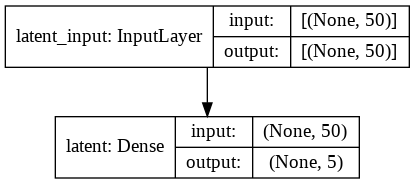

In [10]:
 plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
#x_train = np.expand_dims(X_train, -1)
#print(X_train.shape)

model.compile(optimizer= 'Adam')
model.fit(X_train, epochs=30, batch_size=128)

Epoch 1/30


ValueError: ignored

In [ ]:
'''
Test code for functional structure VAE

encoder_inputs = Input(shape = (n, ))
x = Dense(100, activation="relu")(encoder_inputs)
x = Dense(60, activation="relu")(x)
x = Dense(10, activation = 'relu')(x)


#latent/ bottleneck
z_mean = Dense(latent_dim, name = "z_mean")(x)
z_log_var = Dense(latent_dim, name="z_log_var")(x)


z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
'''

In [ ]:
'''
latent_inputs = Input(shape = (latent_dim, ))
x = Dense(100, activation="relu")(latent_inputs)
x = Dense(60, activation="relu")(x)
decoder_outputs = Dense(50, activation="relu")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()
'''

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

  #computing the gradient with GradientTape
    def train_step(self, data):
        with GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon